In [2]:
import numpy as np 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVR # nu-SVR, implement from libsvm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn import preprocessing
# different regressor test

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet

import pandas as pd # process txt
from scipy.io import loadmat
from PIL import Image

from collections import defaultdict

0. 整理好语义表示 $a_c$，视觉特征 $x_n$
1. 创建视觉特征代表：PCA转换后的数据的平均值 $v_c = \frac {1} {|I_c|} \sum_{n \in I_c} M x_n$
2. 训练$\nu$-SVR回归器：$\psi (a_c) \approx v_c$，注意是对每一个维度进行预测，理由是PCA将数据的各个维度独立开了。
3. 预测未见类的视觉特征代表：$\psi (a_u) = v_u$
4. 新的数据点: $\hat y = arg \min dis_{NN} (\psi(M x), v_u) $


## **第0步**

In [3]:
folder = "G:/dataset/awa/"

standard_path = "G:/dataset/standard_split/AWA2/"
proposed_path = "G:/dataset/proposed_split/AWA2/" 

cls_to_idx = {}
with open(folder + "classes.txt", "r", encoding='utf-8') as f:
     for row in f.readlines():
         row = row.rstrip()
         idx, name = row.split()
         cls_to_idx[name] = int(idx)

sstrain, sstest = [], []
pstrain, pstest = [], []

with open(standard_path + "trainvalclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        sstrain.append(cls_to_idx[row])

with open(standard_path + "testclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        sstest.append(cls_to_idx[row])

print("standard_split:", len(sstrain), len(sstest))
# transform List(str) -> List(int)

with open(proposed_path + "trainvalclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        pstrain.append(cls_to_idx[row])

with open(proposed_path + "testclasses.txt", "r", encoding='utf-8') as f:
    for row in f.readlines():
        row = row.rstrip()
        pstest.append(cls_to_idx[row])

print("proposed_split:", len(pstrain), len(pstest))

# Random Train & Test Class Split
X_class = list(range(1, 51))
train_class, test_class = train_test_split(X_class, test_size=0.2)

train_class, test_class = sstrain, sstest
train_class, test_class = pstrain, pstest

# labels
#yp = folder + "ResNet101/AwA2-labels.txt"
#y = np.loadtxt(yp, delimiter=" ", encoding='utf-8')


# visual features 2048 dimensions
#xp = folder + "ResNet101/AwA2-features.txt"
#x = np.loadtxt(xp, delimiter=" ", encoding='utf-8')

standard_split: 40 10
proposed_split: 40 10


In [4]:
test_class

[23, 50, 30, 24, 9, 34, 7, 47, 31, 41]

In [5]:
# semantic embedding of AwA2, 85 attibutes
seb = folder + "predicate-matrix-binary.txt" 
se = folder + "predicate-matrix-continuous.txt" 
# np.loadtxt(seb, delimiter=" ", encoding='utf-8'), binary works perfectly
# np.loadtxt(se, delimiter="  ", encoding='utf-8') # single, double, triple space exists
semat = np.zeros((50, 85))
with open(se, 'r', encoding='utf-8') as f:
    rows = f.readlines()
    cnt = 0
    for row in rows:
        row = row.strip()
        semat[cnt, :] = np.array(row.split(), dtype='float64')
        cnt = cnt + 1

semat.shape # unnormalize
# semat = preprocessing.normalize(semat) 
# 标准化后和essay evaluation的一模一样

(50, 85)

In [6]:
# 写成一个类方便其他人使用？
# combine x_n and y_n to a class
class awaRead:
    def __init__(self, p, train_split):
        """
        p: 数据集存放路径
        train_split: 给出训练集
        """
        X_class = list(range(1, 51))
        train_class = train_split
        test_class = list(filter(lambda i: i not in train_class, X_class))
        self.path = p
        # labels
        yp = self.path + "ResNet101/AwA2-labels.txt"
        y = np.loadtxt(yp, delimiter=" ", encoding='utf-8')
        # visual features 2048 dimensions
        xp = self.path + "ResNet101/AwA2-features.txt"
        x = np.loadtxt(xp, delimiter=" ", encoding='utf-8')
        self.i1 = np.isin(y, train_class)
        self.i2 = np.isin(y, test_class)
        self.X_train, self.X_test = x[self.i1], x[self.i2]
        self.y_train, self.y_test = y[self.i1], y[self.i2]
    def index_train_test(self):
        return [self.i1, self.i2]
    def train_data(self):
        return self.X_train, self.y_train
    def test_data(self):
        return self.X_test, self.y_test
    def test(self):
        print(self.X_train.shape, self.y_train.shape)
        print(self.X_test.shape, self.y_test.shape)



#len(test_class), len(train_class) # (10, 40)
awaReader = awaRead(folder, train_class)
awaReader.test()

(29409, 2048) (29409,)
(7913, 2048) (7913,)


In [7]:
X_train, y_train = awaReader.train_data()
X_test, y_test = awaReader.test_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape
## Hyper Parameters

# dimension of PCA

pca_d = 500

In [8]:
exemPCA = decomposition.PCA(n_components=pca_d) # 1024 => 500
exemPCA.fit(X_train)
X_train = exemPCA.transform(X_train)
X_test = exemPCA.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((29409, 500), (29409,), (7913, 500), (7913,))

## **第1步**

$$v_c = \frac {1} {|I_c|} \sum_{n \in I_c} M x_n$$

In [9]:
# group up PCA projections

exem_train_group = defaultdict(list)

for c in train_class:
    exem_train_group[c] = []
        
for x, y in zip(X_train, y_train):
    exem_train_group[y].append(x)


# Average
exem_train = {}
std_train = {}
k = 0

for item in exem_train_group.items():
    y, ary = item
    exem_train[y] = np.mean(ary, axis=0) # Key Sentence
    std_train[y] = np.std(ary, axis=0)

del exem_train_group

trai, tesi = [c-1 for c in train_class], [c-1 for c in test_class] # class to index, start from 0
a_c_train, a_c_test = semat[trai], semat[tesi]
v_c_train = [exem_train[i] for i in train_class] # dict uses classes to index
sd_train = [std_train[i] for i in train_class]
sd_train = np.mean(sd_train, axis=0)
# exem_train.keys(), train_class to test if they match
# e.g. extract the first dimension of exemplar to regression
# v_c_i = [vc[0] for vc in v_c_train]
# v_c_train[:3], v_c_i[:3] # dimension 0 data
# len(v_c_train), len(v_c_train[0]) 40 1024

In [10]:
np.array(a_c_train).shape, np.array(v_c_train).shape, np.array(sd_train).shape

((40, 85), (40, 500), (500,))

## 第2步 
### Training
$\nu$-SVR，注意是对每一个维度。比如说1024个维度，就是用1024个回归器通过语义表示预测每一个维度的数据。


X为语义表示，是固定的a_c_train矩阵，维度为40x85。比如对应第0维的视觉数据y为40x1（对于40x1024），这样就相当于给第一个回归器投入了40个训练数据，一直循环到1024维。

$$\psi (a_c) \approx v_c$$

## 第3步
### Predicting

对于a_c_test(10x85)，依次使用回归器预测出10x1的一个维度的结果，填入结果的一个列中。循环了1024次后得到10x1024的矩阵，这就是我们要求的未见类的视觉特征代表。

$\psi (a_u) = v_u$

## 第4步
### Testing
突然发现如果是做零样本学习，exem_X就不该加入可见类

$\hat y = arg \min dis_{NN} (\psi(M x), v_u) $

最近邻分类器，X (10, 1024) y (10, 1)

注意v_c_test的顺序，由a_c_test决定，所以根据tesi来分配y


In [11]:
regress_group = []
k = 0
for j in range(pca_d):
    X = a_c_train # 
    y = [vc[j] for vc in v_c_train]
    regressor = Lasso()
    #regressor = NuSVR(C=2)
    regressor.fit(X, y)
    regress_group.append(regressor)

# validate
# regress_group[10].predict([a_c_train[3]]), v_c_train[3][10]
# regress_group[4].predict(a_c_test), regress_group[5].predict(a_c_test)

v_c_test = np.zeros((10, pca_d)) # 提前定义好exemplar矩阵
# 对每一个维度进行预测
for j in range(pca_d):
    v_c_test[:, j] =  regress_group[j].predict(a_c_test) # 10 dimension , assign to column

print(v_c_test.shape, len(v_c_train), len(v_c_train[0]))

exem_X, exem_y = [], []

for i, c in enumerate(test_class):
    exem_X.append(v_c_test[i])
    exem_y.append(c)

# Add this part to become GZSL
#for i, c in enumerate(train_class):
#    exem_X.append(v_c_train[i])
#    exem_y.append(c)

#X_test.shape
# exem_X.shape, exem

#exem_X, exem_y = [], []

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(exem_X, exem_y)
print("1NN:{} ".format(neigh.score(X_test, y_test)))

sneigh = KNeighborsClassifier(n_neighbors=1, metric='seuclidean', 
                    metric_params={'V':sd_train})
sneigh.fit(exem_X, exem_y)
print("1NNs:{}".format(sneigh.score(X_test, y_test)))

(10, 500) 40 500
1NN:0.6515859977252623 
1NNs:0.6333880955389865


In [13]:
i_to_c = {}

for k, v in cls_to_idx.items():
    i_to_c[v] = k


In [15]:
imgs = np.loadtxt(folder + "ResNet101/AwA2-filenames.txt", dtype=str, encoding='utf-8')
train_index, test_index = awaReader.index_train_test()

        
# imgs[test_index]
ary = sneigh.predict(X_test)
temp = ary == y_test

In [19]:
imgs[1].split("_")[0]

'antelope'

In [22]:
folder + "JPEGImages/" + imgs[1].split("_")[0] + "/" + imgs[1]

'G:/dataset/awa/JPEGImages/antelope/antelope_10002.jpg'

In [27]:
def predict(ix, paths):
    print("预测: ")
    l = sneigh.predict(X_test[[ix]])
    print("    " + i_to_c[l[0]])
    print("实际:")
    print("    " , paths[ix].split('/')[-1])
    print("邻居[类别, 距离]:")
    neigh_dist, neigh_indices = sneigh.kneighbors(X_test[[ix]], n_neighbors=5)
    for d, i in zip(neigh_dist[0], neigh_indices[0]):
        ti = exem_y[i]
        print("   " + i_to_c[ti], d, sep=", ")
    im = Image.open(folder + "JPEGImages/" + paths[ix].split("_")[0] + "/" + paths[ix])
    plt.imshow(im)
    print(temp[ix])


预测: 
    sheep
实际:
     bat_10178.jpg
邻居[类别, 距离]:
   sheep, 33.08078584440734
   bat, 33.10483175192276
   rat, 33.30047464147692
   bobcat, 33.52885817938129
   dolphin, 33.7421662705964
False


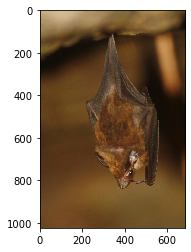

In [28]:
predict(177, imgs[test_index])

预测: 
    bobcat
实际:
     bobcat_10110.jpg
邻居[类别, 距离]:
   bobcat, 19.046145953114845
   bat, 20.91873912698708
   seal, 21.646828975909838
   rat, 21.666844593483415
   sheep, 21.82642983150737
True


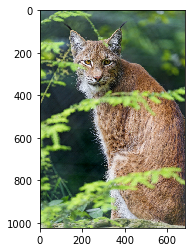

In [30]:
predict(666, imgs[test_index])

预测: 
    blue+whale
实际:
     blue+whale_10052.jpg
邻居[类别, 距离]:
   blue+whale, 27.26842575461933
   dolphin, 28.543240993333516
   seal, 28.60032735092766
   horse, 30.80702090420903
   walrus, 30.959913823962818
True


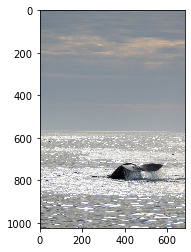

In [32]:
predict(434, imgs[test_index])

### GZSL 

In [36]:
regress_group = []
k = 0
for j in range(pca_d):
    X = a_c_train # 
    y = [vc[j] for vc in v_c_train]
    regressor = Lasso()
    regressor.fit(X, y)
    regress_group.append(regressor)

v_c_test = np.zeros((10, pca_d)) # 提前定义好exemplar矩阵
# 对每一个维度进行预测
for j in range(pca_d):
    v_c_test[:, j] =  regress_group[j].predict(a_c_test) # 10 dimension , assign to column

print(v_c_test.shape, len(v_c_train), len(v_c_train[0]))

exem_X, exem_y = [], []

for i, c in enumerate(test_class):
    exem_X.append(v_c_test[i])
    exem_y.append(c)

# Add this part to become GZSL
for i, c in enumerate(train_class):
    exem_X.append(v_c_train[i])
    exem_y.append(c)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(exem_X, exem_y)
print("1NN:{} ".format(neigh.score(X_test, y_test)))

sneigh = KNeighborsClassifier(n_neighbors=1, metric='seuclidean', 
                    metric_params={'V':sd_train})
sneigh.fit(exem_X, exem_y)
print("1NNs:{}".format(sneigh.score(X_test, y_test)))

(10, 500) 40 500
1NN:0.14002274737773285 
1NNs:0.13269303677492733


预测: 
    bobcat
实际:
     bobcat_10110.jpg
邻居[类别, 距离]:
   bobcat, 19.046145953114845
   fox, 20.310766905022305
   raccoon, 20.495026810790534
   siamese+cat, 20.705440801519863
   bat, 20.91873912698708
True


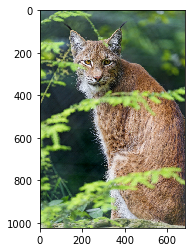

In [34]:
ary = sneigh.predict(X_test)
temp = ary == y_test

predict(666, imgs[test_index])

In [ ]:
#X_test[:2], y_test[:2], v_c_test[6], v_c_test[6].shape
#neigh.predict(X_test[:2])

In [ ]:
#accuracy = neigh.score(X_test, y_test)

In [ ]:
#accuracy 
# 
#  4/3 Random Splt
#  0.6214436868093111 ZSL
#  0.26980954620268044 GZSL
# 4/12 Standard Split
# 0.658267716535433 ZSL
# 0.10966356478167502 GZSL 
# 4/13 Proposed Split
# 0.3626943005181347 ZSL
# 0.1228358397573613 GZSL
# 4/14 Standard Split with original continuous semantic embedding 
# 0.7448818897637796 ZSL
# 0.14373657838224768 GZSL

In [ ]:
#X_test.shape, y_test.shape, np.array(exem_X).shape, np.array(exem_y).shape

In [ ]:
## Save Exemplars and visual features of test class
#save_path = "./lasso_exem/"
#np.save(save_path + "exem_test.npy", np.array(exem_X))
#np.save(save_path + "X_test.npy", X_test)
#np.savetxt(save_path + "y_test.txt", np.array(y_test, dtype=int), fmt='%s', encoding='utf-8')

### 实验结果

> 最初的结果都使用了binary的语义表示，原版给了一个未标准化的，

- 4/3 Random Splt C=2

0.6214436868093111 ZSL,
0.26980954620268044 GZSL

- 4/12 Standard Split C=2

0.658267716535433 ZSL,
0.10966356478167502 GZSL 

- 4/13 Proposed Split C=2

0.3626943005181347 ZSL,
0.1228358397573613 GZSL

- 4/14 Standard Split with original continuous semantic embedding
    - C = default|| 0.7448818897637796 ZSL
    - C = 2 || 0.7730851825340014 ZSL
    try to use different regressor:
    - GradientBoostingRegressor 0.6641374373657838 
    - SVR 0.7589119541875448
    - LinearSVR 0.6943450250536864
    - LinearRegression 0.697494631352899
    - Lasso 0.7156764495347172
    - Ridge 0.697780959198282

- 4/16 Proposed Split with continuous semantic embedding
    - C = 2 || 0.5937065588272463 ZSL
    - C = defalut || 0.5348161253633261 ZSL
    - SVR || 0.4821180336155693 ZSL